<h1 style="text-align: center;">Auralyse Model Training</h1>

## Introduction
In this notebook, we explore the development of a speech emotion recognition (SER) model using deep neural networks and its conversion into a TinyML model.

The dataset employed in this notebook is a combination of three datasets: RAVDESS [[1]], TESS [[2]], and SAVEE [[3]. We will load and preprocess the data before exploring and visualizing wave plots and spectrograms for different emotions. We utilize data augmentation techniques such as noise addition, stretching, and pitching to expand the dataset and enhance the model's performance.

Upon completing the standard training and validation pipeline, we convert the model into a TensorFlow Lite (TFLite) format, quantize it to reduce the size, and compare its inference time with that of the original model.

Reference:<br>
[[1]] Livingstone, Steven R., and Frank A. Russo. "The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English." PloS one 13.5 (2018): e0196391.<br>
[[2]] Dupuis, Kate, and M. Kathleen Pichora-Fuller. "Toronto emotional speech set (tess)-younger talker_happy." (2010).<br>
[[3]] Jackson, Philip, and SJUoSG Haq. "Surrey audio-visual expressed emotion (savee) database." University of Surrey: Guildford, UK (2014).

[1]: https://doi.org/10.1371/journal.pone.0196391
[2]: https://doi.org/10.5683/SP2/E8H2MF
[3]: https://openresearch.surrey.ac.uk/esploro/outputs/journalArticle/Surrey-audio-visual-expressed-emotion-savee-database/99635364402346

## Importing Libraries
Include the necessary libraries for data manipulation, visualization, and model building:

In [1]:
import os
import sys
import time

from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

from google.colab import drive
import zipfile

## Dataset
We will use three different datasets for speech emotion recognition: RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song), TESS (Toronto Emotional Speech Set), and SAVEE (Surrey Audio-Visual Expressed Emotion). These datasets offer several benefits that contribute to the development of more robust and accurate SER models:

1. Variety of emotional expressions:<br> These datasets encompass a wide range of emotions, such as happy, sad, angry, fearful, surprised, disgusted, and neutral. This variety helps train models to recognize and distinguish subtle differences between various emotional expressions, enhancing their performance.

2. Multiple speakers:<br> Including multiple speakers with different accents, genders, and speaking styles provide a more diverse and representative speech data sample. This diversity helps models generalize to real-world scenarios, making them more effective in handling speech data from various sources.

3. High-quality recordings:<br> The audio files in these datasets are recorded with high-quality equipment, resulting in clear and consistent audio samples, allowing models to focus on the emotional content of the speech without being hindered by noise or other artifacts.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = "/content/drive/MyDrive/"

ravdess_zip = base_path + "Radvess.zip"
tess_zip = base_path + "TESS.zip"
savee_zip = base_path + "SAVEE.zip"


In [4]:
# Unzipping the Ravdess data
with zipfile.ZipFile(ravdess_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/ravdess_data")

# Unzipping the Tess data
with zipfile.ZipFile(tess_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/tess_data")

# Unzipping the Savee data
with zipfile.ZipFile(savee_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/savee_data")


In [5]:
Ravdess = "/content/ravdess_data/audio_speech_actors_01-24/"
Tess = "/content/tess_data/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/savee_data/ALL/"

In [6]:
emotion_to_valence_arousal = {
    'happy':    (0.9, 0.9),  # Positive valence, high arousal
    'sad':      (-0.9, -0.5),  # Negative valence, low arousal
    'angry':    (-0.9, 0.9),  # Negative valence, high arousal
    'fear':     (-0.7, 0.8),  # Negative valence, high arousal
    'disgust':  (-0.8, 0.6),  # Negative valence, mid-high arousal
    'surprise': (0.7, 0.8),  # Positive valence, high arousal
    'neutral':  (0.0, 0.0)   # Neutral valence, neutral arousal
}

In [7]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Change integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

Ravdess_df.head()

,Emotions,Path
0,fear,/content/ravdess_data/audio_speech_actors_01-2...
1,sad,/content/ravdess_data/audio_speech_actors_01-2...
2,angry,/content/ravdess_data/audio_speech_actors_01-2...
3,happy,/content/ravdess_data/audio_speech_actors_01-2...
4,sad,/content/ravdess_data/audio_speech_actors_01-2...


In [8]:
Ravdess_df['Valence'] = Ravdess_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][0])
Ravdess_df['Arousal'] = Ravdess_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][1])

# Checking the updated DataFrame:
Ravdess_df.head()


,Emotions,Path,Valence,Arousal
0,fear,/content/ravdess_data/audio_speech_actors_01-2...,-0.7,0.8
1,sad,/content/ravdess_data/audio_speech_actors_01-2...,-0.9,-0.5
2,angry,/content/ravdess_data/audio_speech_actors_01-2...,-0.9,0.9
3,happy,/content/ravdess_data/audio_speech_actors_01-2...,0.9,0.9
4,sad,/content/ravdess_data/audio_speech_actors_01-2...,-0.9,-0.5


In [9]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

print(Tess_df)

      Emotions                                               Path
0         fear  /content/tess_data/tess toronto emotional spee...
1         fear  /content/tess_data/tess toronto emotional spee...
2         fear  /content/tess_data/tess toronto emotional spee...
3         fear  /content/tess_data/tess toronto emotional spee...
4         fear  /content/tess_data/tess toronto emotional spee...
...        ...                                                ...
2795  surprise  /content/tess_data/tess toronto emotional spee...
2796  surprise  /content/tess_data/tess toronto emotional spee...
2797  surprise  /content/tess_data/tess toronto emotional spee...
2798  surprise  /content/tess_data/tess toronto emotional spee...
2799  surprise  /content/tess_data/tess toronto emotional spee...

[2800 rows x 2 columns]


In [10]:
# Replacing emotion names to match RAVDESS naming
emotion_replacements = {
    'happy': 'happy',
    'sad': 'sad',
    'angry': 'angry',
    'fearful': 'fear',
    'disgust': 'disgust',
    'surprised': 'surprise',
    'neutral': 'neutral',
    'surprise': 'surprise'  # added for consistency
}

Tess_df['Emotions'] = Tess_df['Emotions'].map(emotion_replacements)

Tess_df = Tess_df.dropna(subset=['Emotions'])
Tess_df['Valence'] = Tess_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][0])
Tess_df['Arousal'] = Tess_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][1])

# Checking the updated DataFrame:
Tess_df.head()


<ipython-input-10-0487767b3e22>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tess_df['Valence'] = Tess_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][0])
<ipython-input-10-0487767b3e22>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tess_df['Arousal'] = Tess_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][1])


,Emotions,Path,Valence,Arousal
200,neutral,/content/tess_data/tess toronto emotional spee...,0.0,0.0
201,neutral,/content/tess_data/tess toronto emotional spee...,0.0,0.0
202,neutral,/content/tess_data/tess toronto emotional spee...,0.0,0.0
203,neutral,/content/tess_data/tess toronto emotional spee...,0.0,0.0
204,neutral,/content/tess_data/tess toronto emotional spee...,0.0,0.0


In [11]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

Savee_df.head()

,Emotions,Path
0,disgust,/content/savee_data/ALL/JE_d06.wav
1,neutral,/content/savee_data/ALL/JK_n04.wav
2,sad,/content/savee_data/ALL/KL_sa03.wav
3,fear,/content/savee_data/ALL/KL_f08.wav
4,fear,/content/savee_data/ALL/JE_f03.wav


In [12]:
# Add Valence and Arousal columns to Savee_df
Savee_df['Valence'] = Savee_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][0])
Savee_df['Arousal'] = Savee_df['Emotions'].map(lambda x: emotion_to_valence_arousal[x][1])

Savee_df.head()


,Emotions,Path,Valence,Arousal
0,disgust,/content/savee_data/ALL/JE_d06.wav,-0.8,0.6
1,neutral,/content/savee_data/ALL/JK_n04.wav,0.0,0.0
2,sad,/content/savee_data/ALL/KL_sa03.wav,-0.9,-0.5
3,fear,/content/savee_data/ALL/KL_f08.wav,-0.7,0.8
4,fear,/content/savee_data/ALL/JE_f03.wav,-0.7,0.8


In [13]:
# Concatenate the dataframes
aggregated_data = pd.concat([Ravdess_df, Tess_df, Savee_df], axis=0)

# Shuffle the dataframe
aggregated_data = aggregated_data.sample(frac=1).reset_index(drop=True)

# Scaling the Valence and Arousal values to be between -1 and 1
aggregated_data['Valence'] = 2 * ((aggregated_data['Valence'] - aggregated_data['Valence'].min()) /
                                  (aggregated_data['Valence'].max() - aggregated_data['Valence'].min())) - 1
aggregated_data['Arousal'] = 2 * ((aggregated_data['Arousal'] - aggregated_data['Arousal'].min()) /
                                  (aggregated_data['Arousal'].max() - aggregated_data['Arousal'].min())) - 1

# Save the dataframe
aggregated_data.to_csv("data_path.csv", index=False)
aggregated_data


,Emotions,Path,Valence,Arousal
0,sad,/content/tess_data/tess toronto emotional spee...,-1.000000,-1.000000
1,angry,/content/ravdess_data/audio_speech_actors_01-2...,-1.000000,1.000000
2,happy,/content/tess_data/tess toronto emotional spee...,1.000000,1.000000
3,sad,/content/ravdess_data/audio_speech_actors_01-2...,-1.000000,-1.000000
4,surprise,/content/tess_data/tess toronto emotional spee...,0.777778,0.857143
...,...,...,...,...
4315,surprise,/content/ravdess_data/audio_speech_actors_01-2...,0.777778,0.857143
4316,happy,/content/tess_data/tess toronto emotional spee...,1.000000,1.000000
4317,sad,/content/tess_data/tess toronto emotional spee...,-1.000000,-1.000000
4318,fear,/content/ravdess_data/audio_speech_actors_01-2...,-0.777778,0.857143


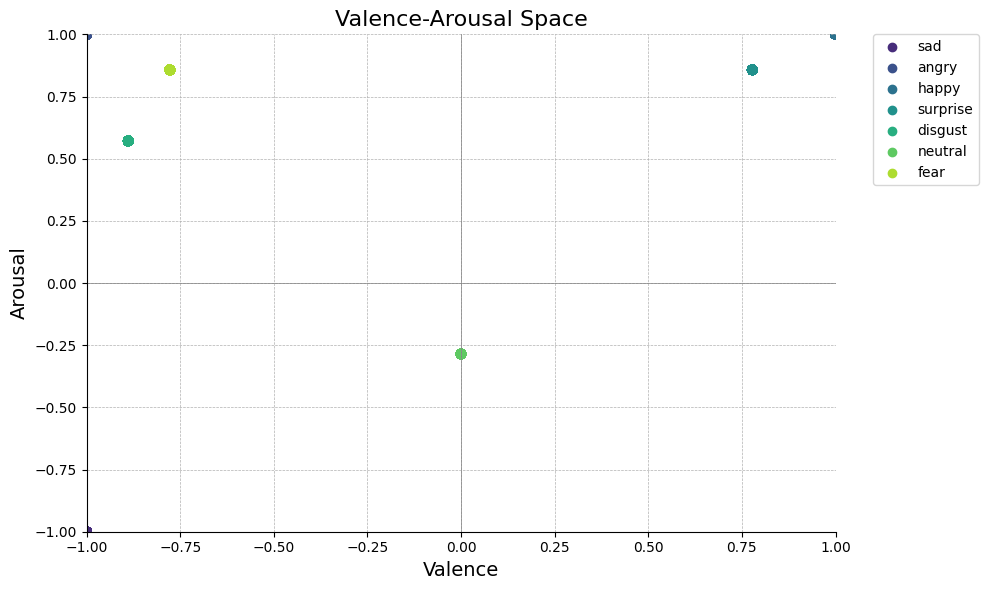

In [14]:
plt.figure(figsize=(10, 6))

# Use a scatter plot to represent Valence and Arousal values
ax = sns.scatterplot(x='Valence',
                     y='Arousal',
                     hue='Emotions',
                     data=aggregated_data,
                     palette='viridis',
                     s=50,
                     alpha=0.6,
                     edgecolor=None)

# Enhancements for better understanding
plt.axhline(0, color='grey', linewidth=0.5)  # Horizontal line at Arousal=0
plt.axvline(0, color='grey', linewidth=0.5)  # Vertical line at Valence=0

# Set title and labels
plt.title('Valence-Arousal Space', size=16)
plt.xlabel('Valence', size=14)
plt.ylabel('Arousal', size=14)

# Set x and y limits to be between -1 and 1 to represent the entire space of valence and arousal
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove the top and right borders for aesthetics
sns.despine(top=True, right=True, left=False, bottom=False)

# Place the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()  # Ensure everything fits without overlap
plt.show()


## Data Exploration
In this section, you've plotted waveforms and spectrograms for emotions data, as well as applied different audio transformations like noise addition, time stretching, and pitch shifting to provide an overview of the audio data properties.

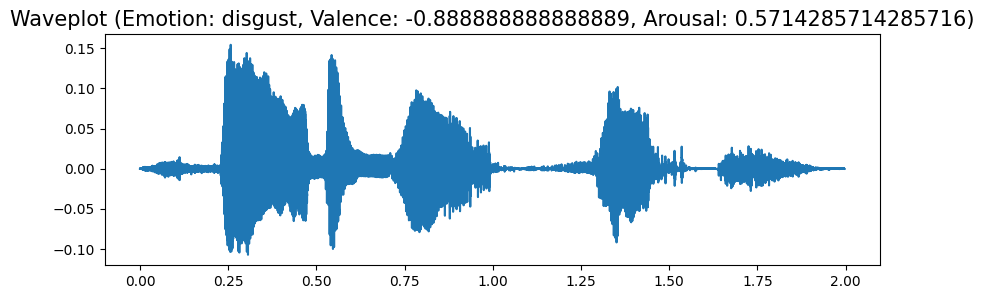

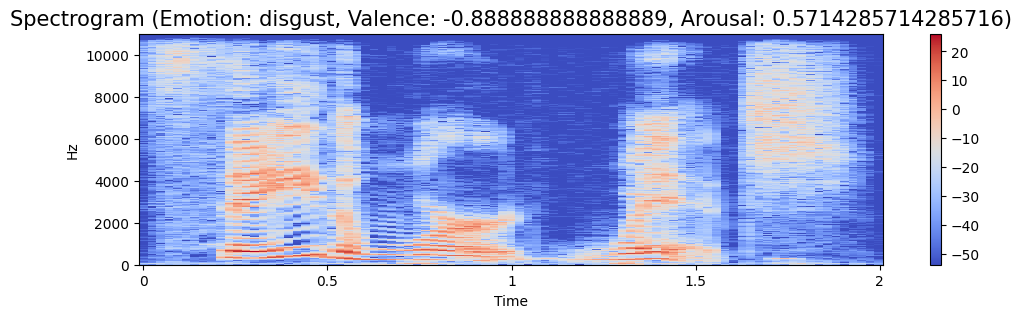

In [15]:
# Define the noise function with adjustable noise level
def noise(data, noise_level=0.05):
    noise_amp = noise_level * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

# Define the functions to create waveplot and spectrogram with emotion label
def create_waveplot(data, sr, va, emotion_label):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot (Emotion: {emotion_label}, Valence: {va[0]}, Arousal: {va[1]})', size=15)
    plt.plot(np.linspace(0, len(data)/sr, num=len(data)), data)
    plt.show()

def create_spectrogram(data, sr, va, emotion_label):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title(f'Spectrogram (Emotion: {emotion_label}, Valence: {va[0]}, Arousal: {va[1]})', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

# Define the stretch and pitch functions
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# Select a random audio file
random_index = np.random.randint(0, len(aggregated_data))
path = aggregated_data.Path.iloc[random_index]
valence = aggregated_data.Valence.iloc[random_index]
arousal = aggregated_data.Arousal.iloc[random_index]
emotion_label = aggregated_data.Emotions.iloc[random_index]

# Load and preprocess the audio data
data, sample_rate = librosa.load(path)
data = librosa.resample(y=data, orig_sr=sample_rate, target_sr=16000)
noised_data = noise(data, noise_level=0.02)  # Adjust noise_level as needed
stretched_data = stretch(data, rate=0.8)
pitched_data = pitch(data, sampling_rate=sample_rate, pitch_factor=0.7)

# Create and display the waveplot and spectrogram with emotion label
create_waveplot(data, sample_rate, (valence, arousal), emotion_label)
create_spectrogram(data, sample_rate, (valence, arousal), emotion_label)
# Play the audio
Audio(data=noised_data, rate=16000)


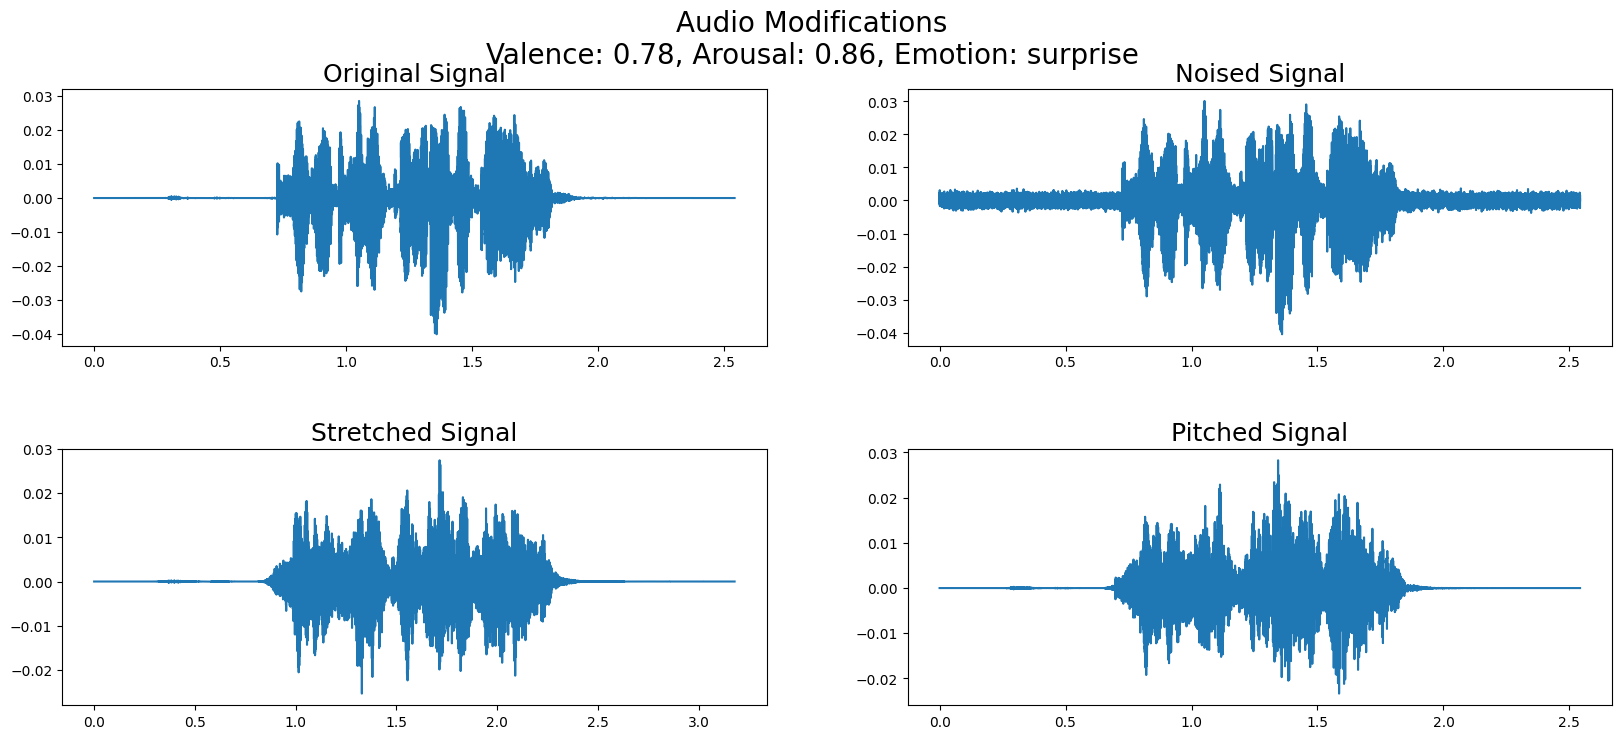

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8))
plt.subplots_adjust(hspace=0.4)

# Fetch random audio sample and its Valence-Arousal values
random_index = np.random.randint(0, len(aggregated_data))
path = aggregated_data.Path.iloc[random_index]
valence = aggregated_data.Valence.iloc[random_index]
arousal = aggregated_data.Arousal.iloc[random_index]
emotion_label = aggregated_data.Emotions.iloc[random_index]

data, sample_rate = librosa.load(path)
data = librosa.resample(y=data, orig_sr=sample_rate, target_sr=16000)

time_vector = np.linspace(0, len(data) / sample_rate, len(data))

# Add overarching title with Valence, Arousal, and Emotion
fig.suptitle(f'Audio Modifications\nValence: {valence:.2f}, Arousal: {arousal:.2f}, Emotion: {emotion_label}', size=20)

# Generate and plot the noised signal
axs[0, 0].set_title('Original Signal', size=18)
axs[0, 0].plot(time_vector, data)

# Generate and plot the noised signal
axs[0, 1].set_title('Noised Signal', size=18)
noised_data = noise(data)
axs[0, 1].plot(time_vector, noised_data)

# Generate and plot the stretched signal
axs[1, 0].set_title('Stretched Signal', size=18)
stretched_data = stretch(data)
time_stretched = np.linspace(0, len(stretched_data) / sample_rate, len(stretched_data))
axs[1, 0].plot(time_stretched, stretched_data)

# Generate and plot the pitched signal
axs[1, 1].set_title('Pitched Signal', size=18)
pitched_data = pitch(data, sample_rate)
time_pitched = np.linspace(0, len(pitched_data) / sample_rate, len(pitched_data))
axs[1, 1].plot(time_pitched, pitched_data)

plt.show()


## Data Pre-processing
This section preprocesses audio data for speech emotion recognition. It encoded emotion labels, extracts features using MFCC, and augments data with audio transformations. The data is stored in a CSV file and split into training, validation, and testing sets for model training.

In [17]:
# Constants
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000

# Feature extraction
def extract_features(data, sample_rate=SAMPLE_RATE):
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    return mfcc.T

# Data augmentation functions
def noise(data):
    noise_amp = 0.5*np.random.uniform()*np.amax(data)
    return data + noise_amp*np.random.normal(size=data.shape[0])

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Augmentation and feature extraction
def augment_and_extract_features(signal, sample_rate, valence, arousal, emotion, data):
    augmentations = [lambda x: x,  # original
                     noise,  # noised
                     lambda x: pitch(stretch(x), sample_rate)]  # stretched and pitched

    for augment in augmentations:
        augmented_signal = augment(signal)
        features = extract_features(augmented_signal, sample_rate)
        data["features"].append(features)
        data["valence"].append(valence)
        data["arousal"].append(arousal)
        data["emotions"].append(emotion)  # Adding emotion labels
    return data

In [18]:
# Data preparation
SAMPLE_NUM = aggregated_data.shape[0]
data = {"features": [], "valence": [], "arousal": [], "emotions": []}
for idx, row in tqdm(aggregated_data.iterrows(), total=SAMPLE_NUM):
    signal, sr = librosa.load(row['Path'], sr=SAMPLE_RATE)
    start_frame, end_frame = int(0.4 * sr), int(1.9 * sr)
    signal = signal[start_frame:end_frame]
    signal = librosa.resample(signal, orig_sr=sr, target_sr=DOWN_SAMPLE_RATE)

    data = augment_and_extract_features(signal, DOWN_SAMPLE_RATE, row['Valence'], row['Arousal'], row['Emotions'], data)

100%|██████████| 4320/4320 [06:57<00:00, 10.34it/s]


In [19]:
# Model preparation
X = tf.keras.preprocessing.sequence.pad_sequences(data["features"])
y_valence = np.array(data["valence"])
y_arousal = np.array(data["arousal"])
y_emotions = np.array(data["emotions"])

# Encoding emotion labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_emotions_encoded = le.fit_transform(y_emotions)

# Splitting data
X_train, X_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test, y_emotions_train, y_emotions_test = train_test_split(
    X, y_valence, y_arousal, y_emotions_encoded, test_size=0.1)
X_train, X_validation, y_valence_train, y_valence_validation, y_arousal_train, y_arousal_validation, y_emotions_train, y_emotions_validation = train_test_split(
    X_train, y_valence_train, y_arousal_train, y_emotions_train, test_size=0.2)

In [20]:
# Determine input shape
sequence_length = X.shape[1]  # Number of time steps per sample
num_features = X.shape[2]  # Number of features at each time step
input_shape = (sequence_length, num_features)

# Determine the number of emotion classes
unique_emotions = np.unique(y_emotions)
num_emotion_classes = len(unique_emotions)

print(f"Input shape: {input_shape}")
print(f"Number of emotion classes: {num_emotion_classes}")


Input shape: (59, 13)
Number of emotion classes: 7


## Model Training 1

In [21]:
# Model Building
def build_model(input_shape, num_emotion_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # 1D CNN layers
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Bidirectional LSTM layers
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Outputs for valence, arousal, and emotion labels
    valence_output = tf.keras.layers.Dense(1, activation='linear', name="valence_output")(x)
    arousal_output = tf.keras.layers.Dense(1, activation='linear', name="arousal_output")(x)
    emotion_output = tf.keras.layers.Dense(num_emotion_classes, activation='softmax', name="emotion_output")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=[valence_output, arousal_output, emotion_output])
    return model

# Constants
input_shape = (59, 13)
num_emotion_classes = 7

# Create and Compile Model
model = build_model(input_shape, num_emotion_classes)
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
              loss={
                  'valence_output': 'mean_squared_error',
                  'arousal_output': 'mean_squared_error',
                  'emotion_output': 'sparse_categorical_crossentropy'
              },
              metrics={
                  'valence_output': 'mae',
                  'arousal_output': 'mae',
                  'emotion_output': 'accuracy'
              })

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 59, 13)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 57, 64)               2560      ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 28, 64)               0         ['conv1d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 26, 128)              24704     ['max_pooling1d[0][0]']   

In [22]:
# Training
EPOCHS = 20
history = model.fit(
    X_train,
    {
        'valence_output': y_valence_train,
        'arousal_output': y_arousal_train,
        'emotion_output': y_emotions_train
    },
    validation_data=(
        X_validation,
        {
            'valence_output': y_valence_validation,
            'arousal_output': y_arousal_validation,
            'emotion_output': y_emotions_validation
        }
    ),
    batch_size=32, epochs=EPOCHS
)


Epoch 1/20
292/292 [==============================] - 25s 24ms/step - loss: 2.6920 - valence_output_loss: 0.6164 - arousal_output_loss: 0.3665 - emotion_output_loss: 1.7091 - valence_output_mae: 0.7091 - arousal_output_mae: 0.4886 - emotion_output_accuracy: 0.3017 - val_loss: 2.2564 - val_valence_output_loss: 0.5351 - val_arousal_output_loss: 0.2447 - val_emotion_output_loss: 1.4766 - val_valence_output_mae: 0.6479 - val_arousal_output_mae: 0.3491 - val_emotion_output_accuracy: 0.4406
Epoch 2/20
292/292 [==============================] - 4s 15ms/step - loss: 2.1538 - valence_output_loss: 0.4821 - arousal_output_loss: 0.2760 - emotion_output_loss: 1.3958 - valence_output_mae: 0.5975 - arousal_output_mae: 0.4017 - emotion_output_accuracy: 0.4510 - val_loss: 1.8634 - val_valence_output_loss: 0.4016 - val_arousal_output_loss: 0.2278 - val_emotion_output_loss: 1.2339 - val_valence_output_mae: 0.5270 - val_arousal_output_mae: 0.3212 - val_emotion_output_accuracy: 0.5191
Epoch 3/20
292/292 [=

In [23]:
# Save Model
output_dir = 'Models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save(os.path.join(output_dir, 'Emotion_Estimation_Model.h5'))
print('Saved the TensorFlow model!')

Saved the TensorFlow model!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
evaluation_results = model.evaluate(
    X_test,
    {
        'valence_output': y_valence_test,
        'arousal_output': y_arousal_test,
        'emotion_output': y_emotions_test
    },
    verbose=0
)

test_loss = evaluation_results[0]
test_valence_mae = evaluation_results[1]
test_arousal_mae = evaluation_results[2]
test_emotion_accuracy = evaluation_results[3]

print("Test Valence Mean Absolute Error: ", test_valence_mae)
print("Test Arousal Mean Absolute Error: ", test_arousal_mae)
print("Test Emotion Accuracy: ", test_emotion_accuracy)

Test Valence Mean Absolute Error:  0.23661649227142334
Test Arousal Mean Absolute Error:  0.1571345329284668
Test Emotion Accuracy:  0.6912534832954407


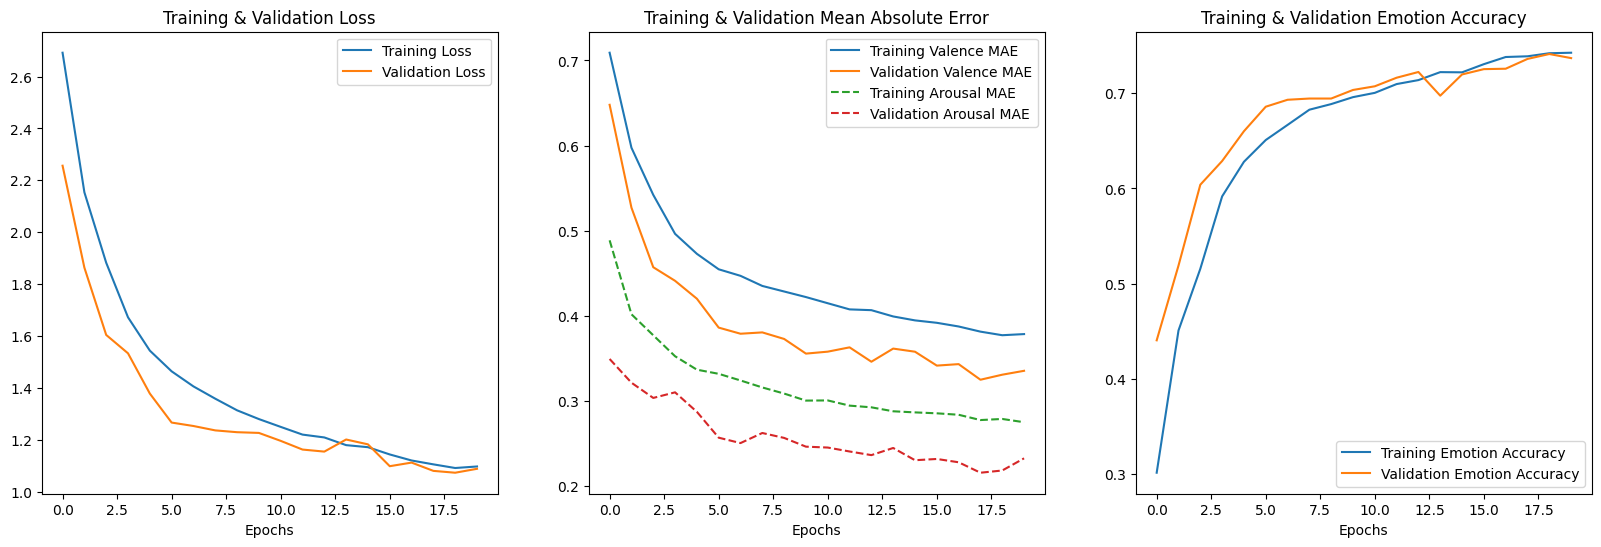

In [25]:
# History plots
EPOCHS = 20
epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Extracting history for plotting
train_mae_valence = history.history['valence_output_mae']
train_mae_arousal = history.history['arousal_output_mae']
train_accuracy_emotion = history.history['emotion_output_accuracy']
train_loss = history.history['loss']

val_mae_valence = history.history['val_valence_output_mae']
val_mae_arousal = history.history['val_arousal_output_mae']
val_accuracy_emotion = history.history['val_emotion_output_accuracy']
val_loss = history.history['val_loss']

# Plotting loss
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Plotting Mean Absolute Error
ax[1].plot(epochs, train_mae_valence, label='Training Valence MAE')
ax[1].plot(epochs, val_mae_valence, label='Validation Valence MAE')
ax[1].plot(epochs, train_mae_arousal, label='Training Arousal MAE', linestyle='--')
ax[1].plot(epochs, val_mae_arousal, label='Validation Arousal MAE', linestyle='--')
ax[1].set_title('Training & Validation Mean Absolute Error')
ax[1].legend()
ax[1].set_xlabel("Epochs")

# Plotting Accuracy
ax[2].plot(epochs, train_accuracy_emotion, label='Training Emotion Accuracy')
ax[2].plot(epochs, val_accuracy_emotion, label='Validation Emotion Accuracy')
ax[2].set_title('Training & Validation Emotion Accuracy')
ax[2].legend()
ax[2].set_xlabel("Epochs")

plt.show()


41/41 [==============================] - 2s 6ms/step


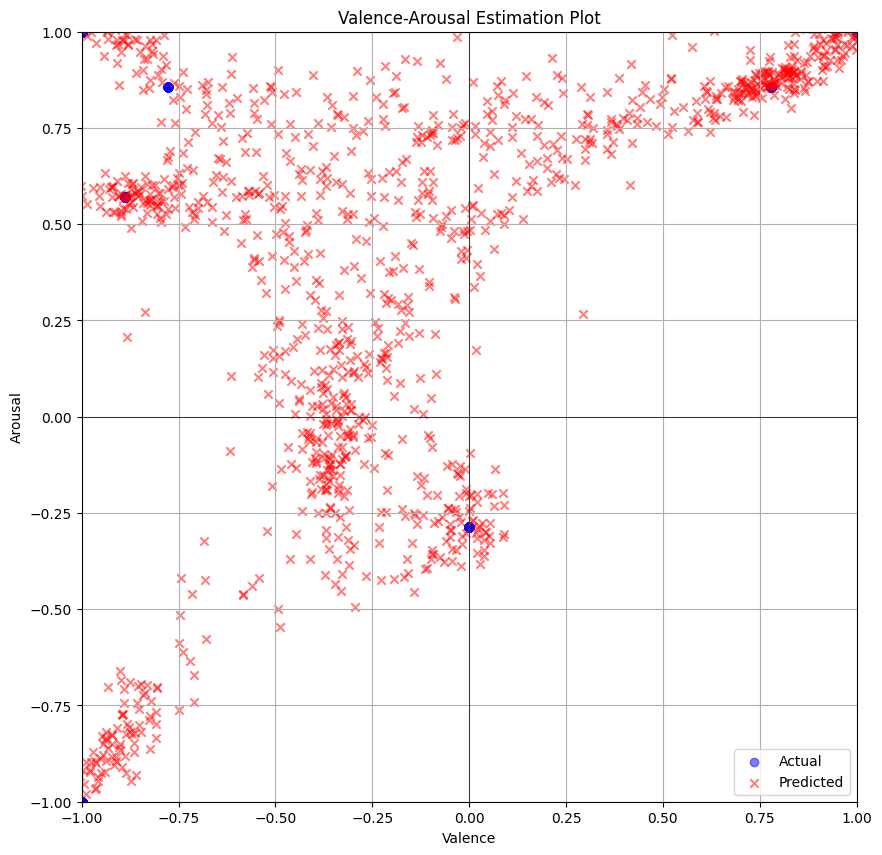

In [26]:
# Plotting Valence and Arousal
def plot_valence_arousal(y_valence_actual, y_arousal_actual, y_valence_pred, y_arousal_pred):
    plt.figure(figsize=(10, 10))
    plt.scatter(y_valence_actual, y_arousal_actual, color='blue', label='Actual', alpha=0.5)
    plt.scatter(y_valence_pred, y_arousal_pred, color='red', marker='x', label='Predicted', alpha=0.5)
    plt.title('Valence-Arousal Estimation Plot')
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.show()

# Predicting values
predictions = model.predict(X_test)
y_valence_pred, y_arousal_pred, y_emotion_pred = predictions[0].flatten(), predictions[1].flatten(), predictions[2].flatten()

# Plotting
plot_valence_arousal(y_valence_test, y_arousal_test, y_valence_pred, y_arousal_pred)


41/41 [==============================] - 0s 7ms/step
(1296, 7)


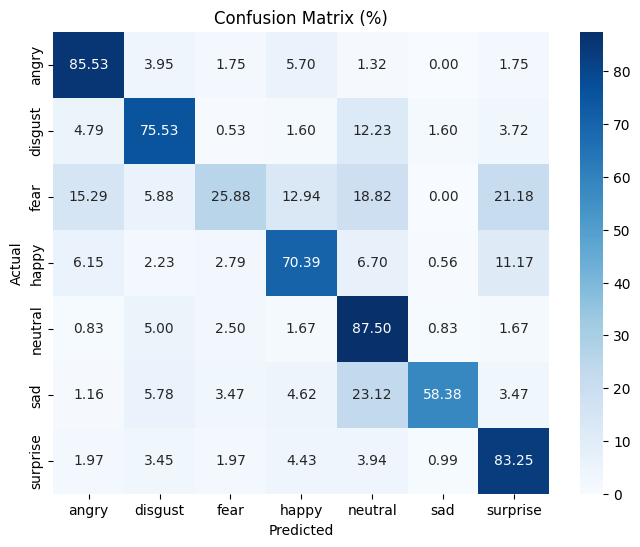

Classification Report (%):
               precision     recall   f1-score      support
angry         82.627119  85.526316  84.051724   228.000000
disgust       75.132275  75.531915  75.331565   188.000000
fear          45.833333  25.882353  33.082707    85.000000
happy         72.413793  70.391061  71.388102   179.000000
neutral       67.307692  87.500000  76.086957   240.000000
sad           92.660550  58.381503  71.631206   173.000000
surprise      74.122807  83.251232  78.422274   203.000000
accuracy      74.459877  74.459877  74.459877     0.744599
macro avg     72.871081  69.494911  69.999219  1296.000000
weighted avg  74.886423  74.459877  73.680106  1296.000000


In [27]:
# Ensure predictions are generated correctly
predictions = model.predict(X_test)
y_valence_pred, y_arousal_pred, y_emotion_pred = predictions

# Check shape
print(y_emotion_pred.shape)  # Debugging line to check shape

# Get the class with the highest probability for each sample
y_emotion_pred_classes = np.argmax(y_emotion_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_emotions_test, y_emotion_pred_classes)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Classification Report
classification_rep = classification_report(y_emotions_test, y_emotion_pred_classes, target_names=le.classes_, output_dict=True)

# Convert to DataFrame for easier manipulation
classification_df = pd.DataFrame(classification_rep).transpose()

# Convert relevant metrics to percentage
classification_df.loc[:, 'precision':'f1-score'] *= 100

print("Classification Report (%):\n", classification_df)


## Model Training 2

In [28]:
def build_improved_model_v2(input_shape, num_emotion_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # 1D CNN layers
    x = tf.keras.layers.Conv1D(128, 3, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(256, 3, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Bidirectional LSTM layers
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Outputs for valence, arousal, and emotion labels
    valence_output_v2 = tf.keras.layers.Dense(1, activation='linear', name="valence_output_v2")(x)
    arousal_output_v2 = tf.keras.layers.Dense(1, activation='linear', name="arousal_output_v2")(x)
    emotion_output_v2 = tf.keras.layers.Dense(num_emotion_classes, activation='softmax', name="emotion_output_v2")(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=[valence_output_v2, arousal_output_v2, emotion_output_v2])
    return model

In [29]:
# Create network
input_shape = (59, 13)
num_emotion_classes = 7
model_v2 = build_improved_model_v2(input_shape, num_emotion_classes)

# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_v2.compile(optimizer=optimiser,
              loss={
                  'valence_output_v2': 'mean_squared_error',
                  'arousal_output_v2': 'mean_squared_error',
                  'emotion_output_v2': 'sparse_categorical_crossentropy'
              },
              metrics={
                  'valence_output_v2': 'mae',
                  'arousal_output_v2': 'mae',
                  'emotion_output_v2': 'accuracy'
              })

# Training with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_emotion_output_v2_accuracy', patience=10, restore_best_weights=True)

EPOCHS = 20
history_v2 = model_v2.fit(
    X_train,
    {
        'valence_output_v2': y_valence_train,
        'arousal_output_v2': y_arousal_train,
        'emotion_output_v2': y_emotions_train
    },
    validation_data=(
        X_validation,
        {
            'valence_output_v2': y_valence_validation,
            'arousal_output_v2': y_arousal_validation,
            'emotion_output_v2': y_emotions_validation
        }
    ),
    batch_size=32, epochs=EPOCHS, callbacks=[early_stopping]
)

Epoch 1/20
292/292 [==============================] - 27s 34ms/step - loss: 2.0806 - valence_output_v2_loss: 0.4610 - arousal_output_v2_loss: 0.2990 - emotion_output_v2_loss: 1.3205 - valence_output_v2_mae: 0.5664 - arousal_output_v2_mae: 0.4183 - emotion_output_v2_accuracy: 0.5106 - val_loss: 1.5518 - val_valence_output_v2_loss: 0.3261 - val_arousal_output_v2_loss: 0.2065 - val_emotion_output_v2_loss: 1.0191 - val_valence_output_v2_mae: 0.4470 - val_arousal_output_v2_mae: 0.2875 - val_emotion_output_v2_accuracy: 0.6232
Epoch 2/20
292/292 [==============================] - 7s 24ms/step - loss: 1.4943 - valence_output_v2_loss: 0.3419 - arousal_output_v2_loss: 0.2134 - emotion_output_v2_loss: 0.9390 - valence_output_v2_mae: 0.4619 - arousal_output_v2_mae: 0.3328 - emotion_output_v2_accuracy: 0.6542 - val_loss: 1.3970 - val_valence_output_v2_loss: 0.2893 - val_arousal_output_v2_loss: 0.1941 - val_emotion_output_v2_loss: 0.9136 - val_valence_output_v2_mae: 0.3850 - val_arousal_output_v2_ma

In [30]:
# Save the model distinctly
model_v2.save('Models/Improved_Valence-Arousal-Emotion-Estimation-Model_v2.h5')
print('Saved the improved TensorFlow model version 2!')

Saved the improved TensorFlow model version 2!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model Training 3

In [31]:
def build_audio_model_3(input_shape, num_emotion_classes):
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

    # 2D CNN layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Flatten the output and use dense layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Outputs
    valence_output_3 = tf.keras.layers.Dense(1, activation='linear', name="valence_output_3")(x)
    arousal_output_3 = tf.keras.layers.Dense(1, activation='linear', name="arousal_output_3")(x)
    emotion_output_3 = tf.keras.layers.Dense(num_emotion_classes, activation='softmax', name="emotion_output_3")(x)

    model_3 = tf.keras.models.Model(inputs=inputs, outputs=[valence_output_3, arousal_output_3, emotion_output_3])

    return model_3

input_shape = (59, 13, 1)
num_emotion_classes = 7
model_3 = build_audio_model_3(input_shape, num_emotion_classes)

# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_3.compile(optimizer=optimiser,
              loss={
                  'valence_output_3': 'mean_squared_error',
                  'arousal_output_3': 'mean_squared_error',
                  'emotion_output_3': 'sparse_categorical_crossentropy'
              },
              metrics={
                  'valence_output_3': 'mae',
                  'arousal_output_3': 'mae',
                  'emotion_output_3': 'accuracy'
              })

# Training with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_emotion_output_3_accuracy', patience=10, restore_best_weights=True)

EPOCHS = 20
history_3 = model_3.fit(
    X_train,
    {
        'valence_output_3': y_valence_train,
        'arousal_output_3': y_arousal_train,
        'emotion_output_3': y_emotions_train
    },
    validation_data=(
        X_validation,
        {
            'valence_output_3': y_valence_validation,
            'arousal_output_3': y_arousal_validation,
            'emotion_output_3': y_emotions_validation
        }
    ),
    batch_size=32, epochs=EPOCHS, callbacks=[early_stopping]
)


Epoch 1/20
292/292 [==============================] - 5s 8ms/step - loss: 17.3013 - valence_output_3_loss: 12.3045 - arousal_output_3_loss: 2.9423 - emotion_output_3_loss: 2.0545 - valence_output_3_mae: 1.0844 - arousal_output_3_mae: 0.8147 - emotion_output_3_accuracy: 0.2600 - val_loss: 2.4493 - val_valence_output_3_loss: 0.5038 - val_arousal_output_3_loss: 0.3588 - val_emotion_output_3_loss: 1.5867 - val_valence_output_3_mae: 0.6197 - val_arousal_output_3_mae: 0.5151 - val_emotion_output_3_accuracy: 0.4672
Epoch 2/20
292/292 [==============================] - 2s 7ms/step - loss: 2.3403 - valence_output_3_loss: 0.4992 - arousal_output_3_loss: 0.3810 - emotion_output_3_loss: 1.4602 - valence_output_3_mae: 0.6029 - arousal_output_3_mae: 0.5204 - emotion_output_3_accuracy: 0.4449 - val_loss: 1.8865 - val_valence_output_3_loss: 0.3964 - val_arousal_output_3_loss: 0.2825 - val_emotion_output_3_loss: 1.2075 - val_valence_output_3_mae: 0.5192 - val_arousal_output_3_mae: 0.4340 - val_emotion_

In [32]:
# Save the model distinctly
model_3.save('Models/Improved_Valence-Arousal-Emotion-Estimation-Model_v3.h5')
print('Saved the improved TensorFlow model version 3!')

Saved the improved TensorFlow model version 3!


## Model Training 4

In [33]:
def build_model_4(input_shape, num_emotion_classes):
    inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

    # 1D Convolutional Layers
    x = layers.Conv1D(128, kernel_size=3, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(256, kernel_size=3, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    # Recurrent Layer
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)

    # Shared Dense Layer
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Task-specific Layers
    valence_output_4 = layers.Dense(1, activation='linear', name="valence_output_4")(x)
    arousal_output_4 = layers.Dense(1, activation='linear', name="arousal_output_4")(x)
    emotion_output_4 = layers.Dense(num_emotion_classes, activation='softmax', name="emotion_output_4")(x)

    model_4 = models.Model(inputs=inputs, outputs=[valence_output_4, arousal_output_4, emotion_output_4])

    return model_4

# Build Model
input_shape = (59, 13)
num_emotion_classes = 7
model_4 = build_model_4(input_shape, num_emotion_classes)

# Compile Model
model_4.compile(optimizer='adam',
                loss={'valence_output_4': 'mean_squared_error',
                      'arousal_output_4': 'mean_squared_error',
                      'emotion_output_4': 'sparse_categorical_crossentropy'},
                metrics={'emotion_output_4': 'accuracy'})

# Train Model
history_4 = model_4.fit(X_train,
                      {'valence_output_4': y_valence_train,
                       'arousal_output_4': y_arousal_train,
                       'emotion_output_4': y_emotions_train},
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_validation, {'valence_output_4': y_valence_validation,
                                                      'arousal_output_4': y_arousal_validation,
                                                      'emotion_output_4': y_emotions_validation}))


Epoch 1/50
292/292 [==============================] - 16s 20ms/step - loss: 2.0767 - valence_output_4_loss: 0.4714 - arousal_output_4_loss: 0.3092 - emotion_output_4_loss: 1.2960 - emotion_output_4_accuracy: 0.5163 - val_loss: 1.6503 - val_valence_output_4_loss: 0.3771 - val_arousal_output_4_loss: 0.2363 - val_emotion_output_4_loss: 1.0369 - val_emotion_output_4_accuracy: 0.6001
Epoch 2/50
292/292 [==============================] - 6s 19ms/step - loss: 1.4706 - valence_output_4_loss: 0.3351 - arousal_output_4_loss: 0.2172 - emotion_output_4_loss: 0.9183 - emotion_output_4_accuracy: 0.6610 - val_loss: 1.3345 - val_valence_output_4_loss: 0.2843 - val_arousal_output_4_loss: 0.1793 - val_emotion_output_4_loss: 0.8710 - val_emotion_output_4_accuracy: 0.6730
Epoch 3/50
292/292 [==============================] - 4s 15ms/step - loss: 1.2802 - valence_output_4_loss: 0.2949 - arousal_output_4_loss: 0.1847 - emotion_output_4_loss: 0.8007 - emotion_output_4_accuracy: 0.7025 - val_loss: 1.1765 - va

In [34]:
# Save the model distinctly
model_4.save('Models/Improved_Valence-Arousal-Emotion-Estimation-Model_v4.h5')
print('Saved the improved model version 4!')

Saved the improved model version 4!


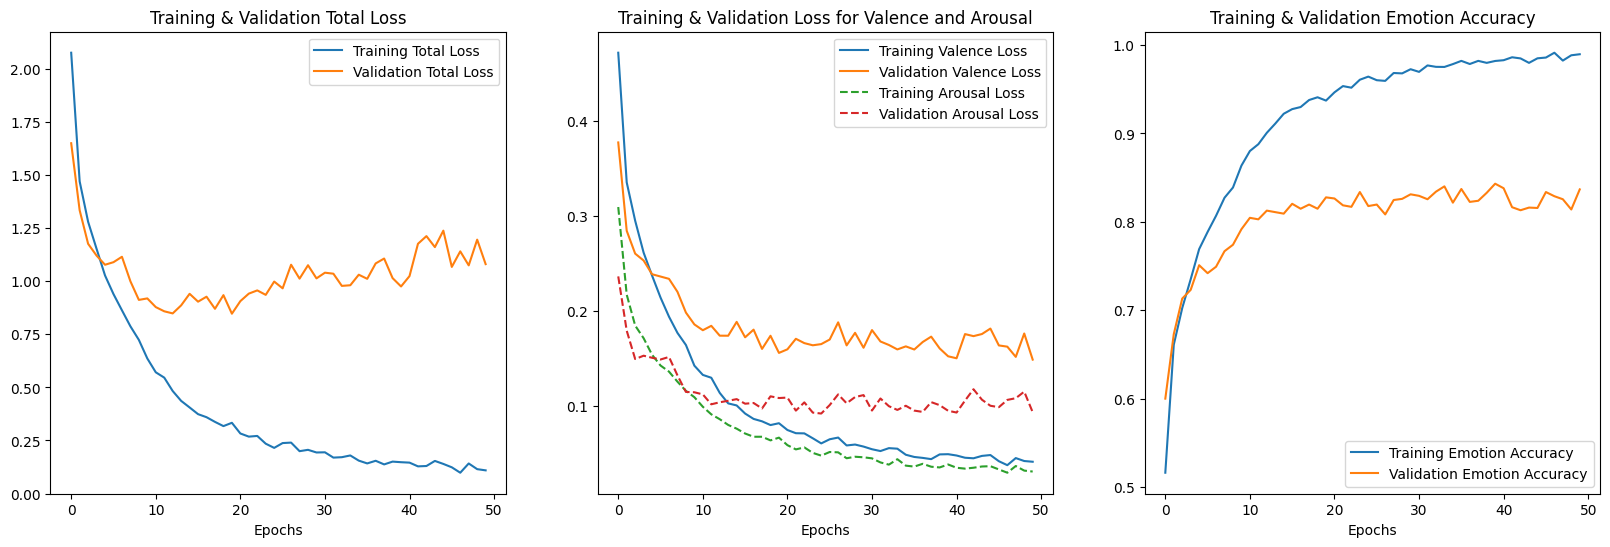

In [35]:
# History plots
EPOCHS = 50
epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Extracting history for plotting from history_4
train_loss_valence_4 = history_4.history['valence_output_4_loss']
train_loss_arousal_4 = history_4.history['arousal_output_4_loss']
train_accuracy_emotion_4 = history_4.history['emotion_output_4_accuracy']

val_loss_valence_4 = history_4.history['val_valence_output_4_loss']
val_loss_arousal_4 = history_4.history['val_arousal_output_4_loss']
val_accuracy_emotion_4 = history_4.history['val_emotion_output_4_accuracy']

# Plotting loss
ax[0].plot(epochs, history_4.history['loss'], label='Training Total Loss')
ax[0].plot(epochs, history_4.history['val_loss'], label='Validation Total Loss')
ax[0].set_title('Training & Validation Total Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

# Plotting Loss for Valence and Arousal
ax[1].plot(epochs, train_loss_valence_4, label='Training Valence Loss')
ax[1].plot(epochs, val_loss_valence_4, label='Validation Valence Loss')
ax[1].plot(epochs, train_loss_arousal_4, label='Training Arousal Loss', linestyle='--')
ax[1].plot(epochs, val_loss_arousal_4, label='Validation Arousal Loss', linestyle='--')
ax[1].set_title('Training & Validation Loss for Valence and Arousal')
ax[1].legend()
ax[1].set_xlabel("Epochs")

# Plotting Accuracy for Emotion
ax[2].plot(epochs, train_accuracy_emotion_4, label='Training Emotion Accuracy')
ax[2].plot(epochs, val_accuracy_emotion_4, label='Validation Emotion Accuracy')
ax[2].set_title('Training & Validation Emotion Accuracy')
ax[2].legend()
ax[2].set_xlabel("Epochs")

plt.show()


41/41 [==============================] - 2s 7ms/step


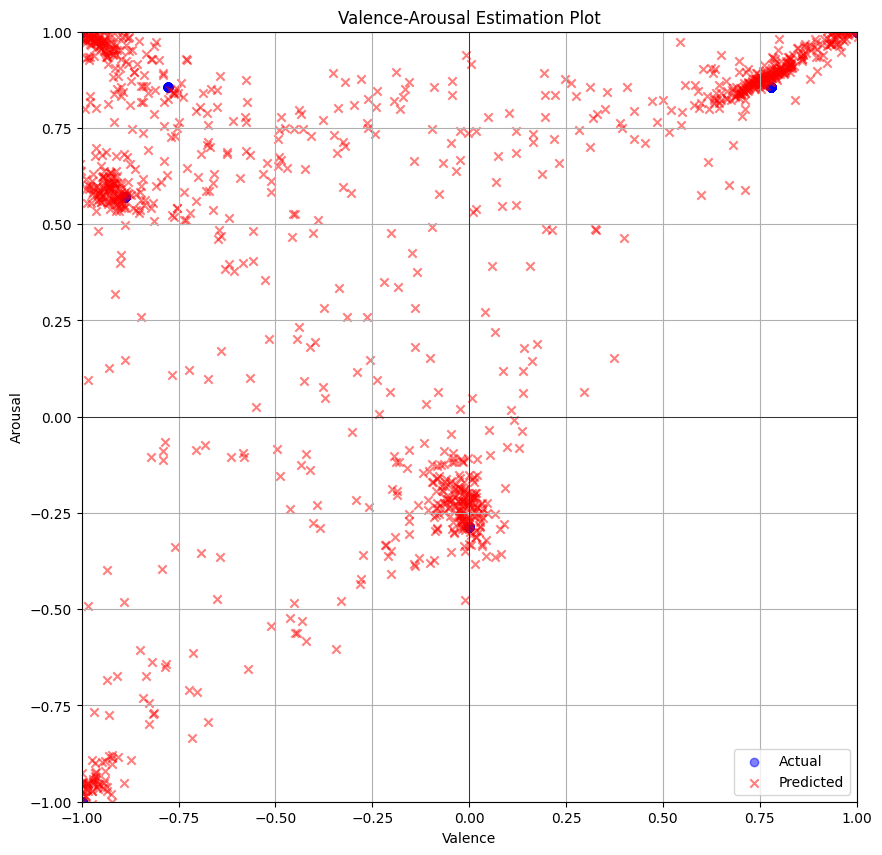

In [36]:
# Predicting values using model_4
predictions_4 = model_4.predict(X_test)
y_valence_pred_4, y_arousal_pred_4, y_emotion_pred_4 = predictions_4[0].flatten(), predictions_4[1].flatten(), predictions_4[2].flatten()

# Plotting Valence and Arousal for model_4
plot_valence_arousal(y_valence_test, y_arousal_test, y_valence_pred_4, y_arousal_pred_4)

41/41 [==============================] - 0s 5ms/step
(1296, 7)


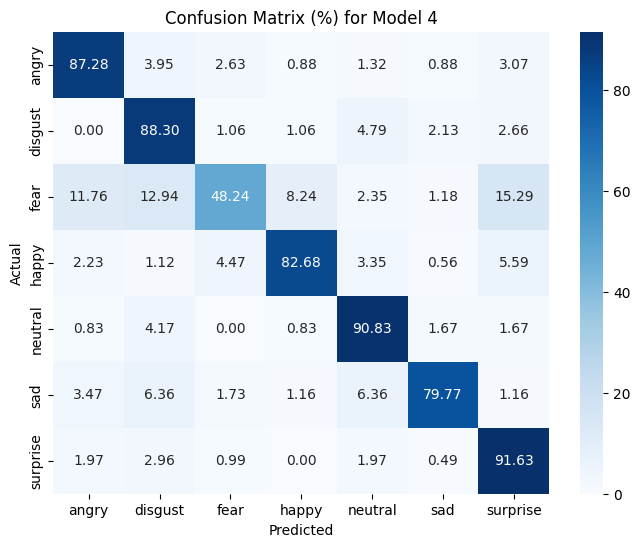

Classification Report (%) for Model 4:
               precision     recall   f1-score      support
angry         88.444444  87.280702  87.858720   228.000000
disgust       77.209302  88.297872  82.382134   188.000000
fear          66.129032  48.235294  55.782313    85.000000
happy         90.797546  82.681564  86.549708   179.000000
neutral       86.166008  90.833333  88.438134   240.000000
sad           91.390728  79.768786  85.185185   173.000000
surprise      81.938326  91.625616  86.511628   203.000000
accuracy      84.567901  84.567901  84.567901     0.845679
macro avg     83.153627  81.246167  81.815403  1296.000000
weighted avg  84.628340  84.567901  84.319115  1296.000000


In [37]:
# Ensure predictions are generated correctly using model_4
predictions_4 = model_4.predict(X_test)
y_valence_pred_4, y_arousal_pred_4, y_emotion_pred_4 = predictions_4

# Check shape
print(y_emotion_pred_4.shape)

# Get the class with the highest probability for each sample
y_emotion_pred_classes_4 = np.argmax(y_emotion_pred_4, axis=1)

# Confusion Matrix for model_4
conf_matrix_4 = confusion_matrix(y_emotions_test, y_emotion_pred_classes_4)
conf_matrix_percentage_4 = conf_matrix_4.astype('float') / conf_matrix_4.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage_4, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%) for Model 4')
plt.show()

# Classification Report for model_4
classification_rep_4 = classification_report(y_emotions_test, y_emotion_pred_classes_4, target_names=le.classes_, output_dict=True)

# Convert to DataFrame for easier manipulation
classification_df_4 = pd.DataFrame(classification_rep_4).transpose()

# Convert relevant metrics to percentage
classification_df_4.loc[:, 'precision':'f1-score'] *= 100

print("Classification Report (%) for Model 4:\n", classification_df_4)

## Model Comparision & Evaluation

In [38]:
# Evaluate the original model
evaluation_results_original = model.evaluate(
    X_test,
    {
        'valence_output': y_valence_test,
        'arousal_output': y_arousal_test,
        'emotion_output': y_emotions_test
    },
    verbose=0
)

# Evaluate the improved model (version 2)
evaluation_results_v2 = model_v2.evaluate(
    X_test,
    {
        'valence_output_v2': y_valence_test,
        'arousal_output_v2': y_arousal_test,
        'emotion_output_v2': y_emotions_test
    },
    verbose=0
)

# Evaluate the improved model (version 3)
evaluation_results_v3 = model_3.evaluate(
    X_test,
    {
        'valence_output_3': y_valence_test,
        'arousal_output_3': y_arousal_test,
        'emotion_output_3': y_emotions_test
    },
    verbose=0
)

# Evaluate Model 4
evaluation_results_4 = model_4.evaluate(
    X_test,
    {
        'valence_output_4': y_valence_test,
        'arousal_output_4': y_arousal_test,
        'emotion_output_4': y_emotions_test
    },
    verbose=0
)

# Extracting metrics
test_valence_mae_original, test_arousal_mae_original, test_emotion_accuracy_original = evaluation_results_original[1], evaluation_results_original[2], evaluation_results_original[3]
test_valence_mae_v2, test_arousal_mae_v2, test_emotion_accuracy_v2 = evaluation_results_v2[1], evaluation_results_v2[2], evaluation_results_v2[3]
test_valence_mae_v3, test_arousal_mae_v3, test_emotion_accuracy_v3 = evaluation_results_v3[1], evaluation_results_v3[2], evaluation_results_v3[3]
test_valence_mae_4, test_arousal_mae_4, test_emotion_accuracy_4 = evaluation_results_4[1], evaluation_results_4[2], evaluation_results_4[3]

# Displaying the results
print("=== Original Model ===")
print(f"Test Valence MAE: {test_valence_mae_original:.4f}")
print(f"Test Arousal MAE: {test_arousal_mae_original:.4f}")
print(f"Test Emotion Accuracy: {test_emotion_accuracy_original:.4f}")

print("\n=== Improved Model (v2) ===")
print(f"Test Valence MAE: {test_valence_mae_v2:.4f}")
print(f"Test Arousal MAE: {test_arousal_mae_v2:.4f}")
print(f"Test Emotion Accuracy: {test_emotion_accuracy_v2:.4f}")

print("\n=== Improved Model (v3) ===")
print(f"Test Valence MAE: {test_valence_mae_v3:.4f}")
print(f"Test Arousal MAE: {test_arousal_mae_v3:.4f}")
print(f"Test Emotion Accuracy: {test_emotion_accuracy_v3:.4f}")

print("\n=== Model 4 ===")
print(f"Test Valence MAE: {test_valence_mae_4:.4f}")
print(f"Test Arousal MAE: {test_arousal_mae_4:.4f}")
print(f"Test Emotion Accuracy: {test_emotion_accuracy_4:.4f}")

=== Original Model ===
Test Valence MAE: 0.2366
Test Arousal MAE: 0.1571
Test Emotion Accuracy: 0.6913

=== Improved Model (v2) ===
Test Valence MAE: 0.1456
Test Arousal MAE: 0.1071
Test Emotion Accuracy: 0.5011

=== Improved Model (v3) ===
Test Valence MAE: 0.3210
Test Arousal MAE: 0.2268
Test Emotion Accuracy: 0.8086

=== Model 4 ===
Test Valence MAE: 0.1532
Test Arousal MAE: 0.1061
Test Emotion Accuracy: 0.8857


## TinyML Model Conversion & Evaluation
To deploy the speech emotion recognition model on mobile app, there are a few steps we have to do to fit in different hardware environments, including post-quantization and model format conversion.

In [39]:
# Create a converter for the 4th model
converter_model4 = tf.lite.TFLiteConverter.from_keras_model(model_4)
converter_model4.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter_model4._experimental_lower_tensor_list_ops = False

# Explicitly set the output order
converter_model4.output_arrays = ['valence_output_4', 'arousal_output_4', 'emotion_output_4']

# Convert the 4th model to TensorFlow Lite
tflite_model_model4 = converter_model4.convert()

# Save the 4th model
with open("Models/model4.tflite", 'wb') as f:
    f.write(tflite_model_model4)

# If you want to optimize the 4th model
converter_model4.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model_model4 = converter_model4.convert()

# Save the optimized 2nd model
with open("Models/SER_quant_model4.tflite", 'wb') as f_quant_model4:
   f_quant_model4.write(quant_tflite_model_model4)

print("Saved TensorFlow 'Lite' models!")

Saved TensorFlow 'Lite' models!


In [40]:
from google.colab import files
files.download("Models/model4.tflite")
files.download("Models/SER_quant_model4.tflite")

print("Saved and downloaded TensorFlow 'Lite' models!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved and downloaded TensorFlow 'Lite' models!


In [41]:
print("Model Sizes:")
!ls -lh Models | awk '{print $5 "\t" $9}'

Model Sizes:
	
2.1M	Emotion_Estimation_Model.h5
7.9M	Improved_Valence-Arousal-Emotion-Estimation-Model_v2.h5
7.7M	Improved_Valence-Arousal-Emotion-Estimation-Model_v3.h5
8.0M	Improved_Valence-Arousal-Emotion-Estimation-Model_v4.h5
2.7M	model4.tflite
723K	SER_quant_model4.tflite


The goal of TinyML techniques is to reduce the model size and the inference time while maintaining similar accuracy.

This concludes our model training. In the future, we would like to use Google's ASR to do speech to text training and develop multimodal models capable of understanding the nuances behind the emotions within speech to text with audio input to further increase model understanding and accuracy. Thank you for looking at this code, please note this complete model training code was written in Google Colab's free version using T4.